# Домашнее задание

### Применение различных методов градиентного спуска

В этом домашнем задании мы потренируемся применять различные методы градиентного спуска на примере классического датасета для предсказания стоимости домов в Калифорнии.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from numpy import random

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 42

### Загрузим датасет

In [2]:
data = fetch_california_housing()
df = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + data['target_names'])
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Разделим датасет на обучающую и тестовую выборки, а также сразу осуществим масштабирование признаков, поскольку в дальнейшем мы будем использовать линейную регрессию.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df[data['feature_names']], df[data['target_names']].values,
                                                    test_size=0.33,
                                                    random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Попробуем применить линейную регрессию "из коробки" и посмотреть, какая получается ошибка на тестовой выборке.

In [4]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f'Ошибка: {np.sum((pred - y_test)**2) / y_test.shape[0]}')

Ошибка: 0.5369686543372459


В итоге мы получили на тестовой выборке некоторое значение ошибки. Давайте теперь попробуем самостоятельно реализовать классический градиентный спуск и сравним значение полученной ошибки

In [17]:
X_new = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

array([1., 1., 1., ..., 1., 1., 1.])

In [11]:
X_train.shape, X_new.shape

((13828, 8), (13828,))

In [18]:
def full_gradient_descent(X, y, lr=0.001, tol=0.0001, max_steps=20000):
  # Добавьте в начало матрицы Х столбец из единиц
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  np.random.seed(RANDOM_SEED)
  w_prev = np.random.rand(X.shape[1], 1)

  # Количество строк в матрице Х
  n = X.shape[0]
  errors = []

  for i in range(max_steps):
    # Значение градиента на шаге i
    grad = - 2 / n * X.T @ (y - X @ w_prev)
    # Шаг градиентного спуска
    w_new = w_prev - lr * grad

    errors.append(((y - X @ w_new)**2).sum() / n)
    # Условие, что норма разности векторов w_new и w_prev меньше tol
    if np.linalg.norm(w_new - w_prev) < tol:
      return w_new, errors
    else:
      w_prev = w_new

  return w_new, errors


def test_error(X, y, w):
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  return ((y - X @ w)**2).sum() / X.shape[0]

In [19]:
%%time
w_fgd, errors_fgd = full_gradient_descent(X_train, y_train)

print(f'Количество итераций: {len(errors_fgd)}')

Количество итераций: 8554
CPU times: user 3.56 s, sys: 1.63 s, total: 5.19 s
Wall time: 2.71 s


Ошибка на тестовой выборке: 0.56785915405439
Значения весов [[ 2.06663614  0.90272471  0.18767006 -0.29860149  0.29710304  0.02317329
  -0.0498699  -0.34309453 -0.32044882]]


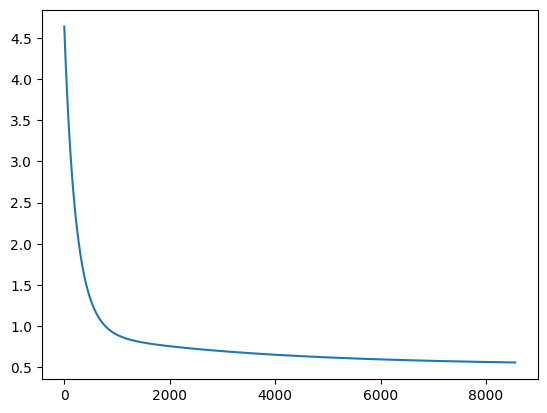

In [20]:
print(f'Ошибка на тестовой выборке: {test_error(X_test, y_test, w_fgd)}')
print('Значения весов', w_fgd.T)
plt.plot(errors_fgd);

Давайте теперь реализуем стохастический градиентный спуск.

In [35]:
def stochastic_gradient_descent(X, y, lr=0.001, tol=0.0001, max_steps=20000):
  # Добавьте в начало матрицы Х столбец из единиц
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  np.random.seed(RANDOM_SEED)
  w_prev = np.random.rand(X.shape[1])

  # Количество строк в матрице Х
  n = X.shape[0]
  errors = []

  for i in range(max_steps):
    # Создайте список из номера одного случайного объекта из выборки
    ind = np.random.randint(0, n)

    X_ind = X[ind, :].reshape(1, -1)
    # Значение градиента на шаге i
    grad = 2 * X_ind.T @ ((X_ind @ w_prev) - y[ind])
    # Шаг градиентного спуска
    w_new = w_prev - lr * grad

    errors.append(((y - X @ w_new)**2).sum() / n)
    # Условие, что норма разности векторов w_new и w_prev меньше tol
    if np.linalg.norm(w_new - w_prev) < tol:
      return w_new, errors
    else:
      w_prev = w_new

  return w_new, errors


In [36]:
%%time
w_sgd, errors_sgd = stochastic_gradient_descent(X_train, y_train)

print(f'Количество итераций: {len(errors_sgd)}')

Количество итераций: 244
CPU times: user 1min 44s, sys: 1min 31s, total: 3min 15s
Wall time: 2min 53s


Ошибка на тестовой выборке: 24572.077693073454
Значения весов [1.07960103 0.8941185  0.60013235 0.40334447 0.0432827  0.22142737
 0.03361304 0.70012945 0.67218878]


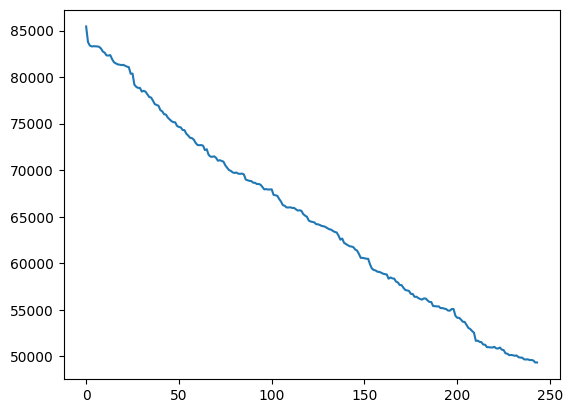

In [37]:
print(f'Ошибка на тестовой выборке: {test_error(X_test, y_test, w_sgd)}')
print('Значения весов', w_sgd.T)
plt.plot(errors_sgd);

Видно, что хоть мы и движемся вниз с точки зрения ошибки на обучающей выборке, мы останавливаемся слишком рано. Подумайте, почему так происходит. Попробуйте уменьшить значение параметра tol и посмотрите, что получится.

In [38]:
%%time
w_sgd, errors_sgd = stochastic_gradient_descent(X_train, y_train, tol=0.00001)

print(f'Количество итераций: {len(errors_sgd)}')

Количество итераций: 1260
CPU times: user 9min 7s, sys: 7min 53s, total: 17min
Wall time: 15min 35s


Ошибка на тестовой выборке: 13975.970616664083
Значения весов [ 1.94675537  0.82909012  0.39157934  0.05928422 -0.06918601  0.13142379
 -0.01282355  0.4608064   0.49975588]


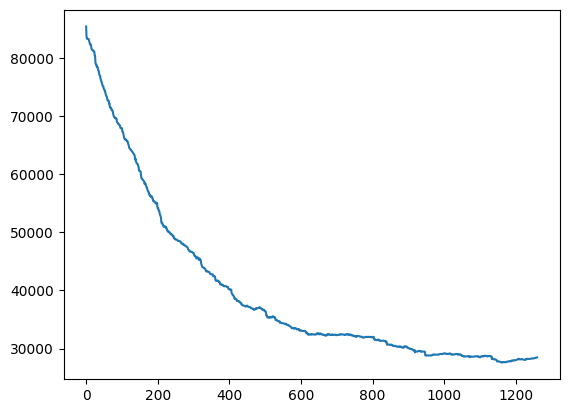

In [39]:
print(f'Ошибка на тестовой выборке: {test_error(X_test, y_test, w_sgd)}')
print('Значения весов', w_sgd.T)
plt.plot(errors_sgd);

Ошибка получилась значительно меньше, но и количество потребовавшихся шагов сильно увеличилось. Давайте теперь попробуем сделать что-то среднее между полным градиентным спуском и стохастическим градиентным спуском (Mini-batch),  добавим сохранение момента и динамический learning rate.

In [42]:
def momentum_gradient_descent(X, y, lr=0.001, tol=0.0001, batch_size=64, alpha=0.9, max_steps=20000):
  # Добавьте в начало матрицы Х столбец из единиц
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  np.random.seed(RANDOM_SEED)
  w_prev = np.random.rand(X.shape[1], 1)

  # Количество строк в матрице Х
  n = X.shape[0]
  errors = []
  momentum = 0

  for i in range(max_steps):
    # Создайте список из batch_size штук случайных объектов из выборки
    ind = np.random.randint(0, n)
    X_ind = X[ind, :].reshape(1, -1)

    # Значение градиента на шаге i
    grad = - 2 * X_ind.T @ (y[ind] - X_ind @ w_prev)
    h = lr * grad
    w_new = w_prev - h

    errors.append(((y - X @ w_new)**2).sum() / n)
    # Условие, что норма разности векторов w_new и w_prev меньше tol
    if np.linalg.norm(w_new - w_prev) < tol:
      return w_new, errors
    else:
      w_prev = w_new
      momentum = h
      # Динамический learning rate
      lr = 0.01 / (i+1)**0.3

  return w_new, errors


In [43]:
%%time
w_mgd, errors_mgd = momentum_gradient_descent(X_train, y_train, tol=0.001)

print(f'Количество итераций: {len(errors_mgd)}')

Количество итераций: 59
CPU times: user 15.5 ms, sys: 23.8 ms, total: 39.3 ms
Wall time: 31.9 ms


Ошибка на тестовой выборке: 2.531472885270542
Значения весов [[ 0.91342543  0.98170949  0.60970622  0.04954996 -0.40724979  0.32798338
   0.04787448  0.67734099  0.65479759]]


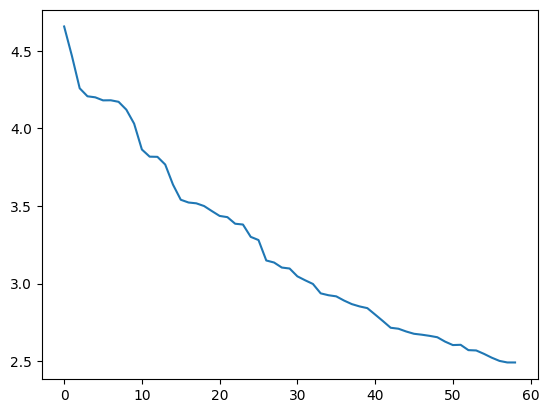

In [44]:
print(f'Ошибка на тестовой выборке: {test_error(X_test, y_test, w_mgd)}')
print('Значения весов', w_mgd.T)
plt.plot(errors_mgd);

Обратите внимание, что с помощью Momentum Mini-batch SGD мы получили даже лучше результат, чем при использовании метода LinearRegression из пакета sklearn. Однако, пришлось заменить значение параметра tol. Подумайте, почему так происходит, и поэкспериментируйте.